## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, History
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

def RMSE(true, predicted):
    MSE_score = MSE(true, predicted)
    return np.round(np.sqrt(MSE_score), decimals=4)

In [2]:
# # Training data
# training_df = pd.read_csv("TrainData.csv")[["TIMESTAMP","POWER"]]; print(training_df.shape)

# # Forecast solutions
# forcast_sol_df = pd.read_csv("Solution.csv")[["TIMESTAMP","POWER"]]; print(forcast_sol_df.shape)

# # Displaying the loaded data
# display(training_df.tail(3))
# display(forcast_sol_df.head(3))

In [3]:
# Training data
training_df = pd.read_csv("entsoe_dataset_main.csv")[["NO5_day_ahead_prices","dato_id"]][0:-8760]; print(training_df.shape)

# Forecast solutions
training_df, forcast_sol_df = train_test_split(training_df, shuffle=False, test_size=0.2, random_state=4155)

# Displaying the loaded data
display(training_df.tail(3))
display(forcast_sol_df.head(3))

(42960, 2)


,NO5_day_ahead_prices,dato_id
34365,41.62,2019-12-02 22:00:00+01:00
34366,40.48,2019-12-02 23:00:00+01:00
34367,40.19,2019-12-03 00:00:00+01:00


,NO5_day_ahead_prices,dato_id
34368,39.73,2019-12-03 01:00:00+01:00
34369,39.51,2019-12-03 02:00:00+01:00
34370,39.43,2019-12-03 03:00:00+01:00


## Time series data processing

### Sliding window process

In [4]:
def create_time_series_data(raw_train_df, raw_forcast_df, nbf_features, nbf_outputs):
    '''
    This method takes inn the training dataframe, and the forcast solution dataframe.
    It also takes in the desired number of features and outputs. 
    The method uses the sliding window algorithm for creating the time-series dataset.
    Finally the method return traning data and test (evaluation) data both as 
    numerical numpy arrays and as dataframes.
    The method does three operations, one just for the training data, one for the 
    test solution, and one where they are combined. This was done to be able to
    investigate the data separatly. However, only the return values are relevant 
    for the traning and evaluation process of the models.
    '''
    nbf_columns = nbf_features + nbf_outputs
    
    # Timeseries combining training and solutions
    train_and_forcast_df = pd.concat([raw_train_df, raw_forcast_df], axis=0)
    ts_df_combined, ts_data_combined = sliding_window_algorithm(train_and_forcast_df,nbf_columns, nbf_features, nbf_outputs)
    ts_df_combined.to_csv("timeseries_combined.csv")
    
    # Timeseries training only
    ts_df_train, ts_data_train = sliding_window_algorithm(raw_train_df,nbf_columns, nbf_features, nbf_outputs)
    ts_df_train.to_csv("timeseries_train.csv")
    
    # Forcast solution only
    ts_df_forcast, ts_data_forcast = sliding_window_algorithm(raw_forcast_df,nbf_columns, nbf_features, nbf_outputs)
    ts_df_forcast.to_csv("timeseries_forcast.csv")
    n_forcasts = raw_forcast_df.shape[0]
    training_data_df = ts_df_combined[:-n_forcasts]; print("training_data_df.shape:", training_data_df.shape)
    
    # Adding timestamp to the training data frame 
    train_timestamps_df = raw_train_df["dato_id"][nbf_features:]; 
    if(nbf_outputs>1):
        train_timestamp = train_timestamps_df.to_numpy()[ :(-nbf_outputs)+1]
    else:
        train_timestamp = train_timestamps_df.to_numpy()
    
    training_data_df.insert(0,'dato_id',train_timestamp)
    training_data_df.to_csv("training_data_processed.csv")

    # Adding timestamp to the evaluation data frame
    evaluation_data_df = ts_df_combined[-n_forcasts:]; print("evaluation_data_df:", evaluation_data_df.shape)
    eval_timestamps_df = raw_forcast_df["dato_id"]
    evaluation_data_df.insert(0,'dato_id',eval_timestamps_df.to_numpy())
    evaluation_data_df.to_csv("evaluation_data_processed.csv")
    
    # Creating numerical and trainable data
    y_train = training_data_df.iloc[:, 1+nbf_features:].to_numpy()
    x_train = training_data_df.iloc[:, 1:1+nbf_features].to_numpy()
    
    # Creating numerical evaluation data
    y_test = evaluation_data_df.iloc[:, 1+nbf_features:].to_numpy()
    x_test = evaluation_data_df.iloc[:, 1:1+nbf_features].to_numpy()
    
    return x_train, y_train, x_test, y_test, training_data_df, evaluation_data_df


def sliding_window_algorithm(raw_data_df, nbf_columns, input_window, output_window):
    raw_data = raw_data_df["NO5_day_ahead_prices"].to_numpy()
    dim0 = raw_data.shape[0] - (nbf_columns - 1) # Number of time-slices
    dim1 = nbf_columns # Time-step length including input window and output window
    data = np.zeros((dim0,dim1)) # Time series matrix
    data[0, :] = raw_data[:dim1] # First initial sample/time-slice (n equals 0)
    n = 1 # n is the count variable
    
    # Looping through the initial input data and constucting the 
    # time series data based on the sliding window approach. 
    # See the report for more descriptions
    for j in range(dim1, raw_data.shape[0]):
        data[n, :-1] = data[n-1, 1:]
        data[n, nbf_columns-1:] = raw_data[j]
        n += 1

    # Creating dataframe    
    feature_names = [f"x{i}" for i in range(1,input_window+1)]
    if(output_window > 1):
        output_names = [f"y{i}" for i in range(1,output_window+1)]    
    else:
        output_names = ["y"]
    
    time_series_df = pd.DataFrame(data=data, columns=feature_names+output_names)
    return time_series_df, data

## Create windowed time series data

In [39]:
# Time series slicing parameters
nbf_features = input_window = 12 
nbf_outputs = output_window = 6

# Creating time series traing and evaluation (test) data besed on sliding window approach
x_train, y_train, x_test, y_test, train_df, eval_df = create_time_series_data(training_df, forcast_sol_df, nbf_features, nbf_outputs)

print(f"{x_test.shape=}")
print(f"{y_test.shape=}")
print(f"{eval_df.shape=}")
print(eval_df.columns)

# Displaying time series data
train_df.index.name = "t"
display(train_df.head())

# Save the table.
train_df.head().to_csv("time_series_data.csv")

training_data_df.shape: (34351, 18)
evaluation_data_df: (8592, 18)
x_test.shape=(8592, 12)
y_test.shape=(8592, 6)
eval_df.shape=(8592, 19)
Index(['dato_id', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6'],
      dtype='object')


,dato_id,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y1,y2,y3,y4,y5,y6
t,,,,,,,,,,,,,,,,,,,
0,2016-01-01 13:00:00+01:00,16.04,15.74,15.57,15.47,15.75,15.36,15.37,15.19,15.39,15.78,16.15,16.50,16.72,17.17,18.00,18.53,19.11,18.68
1,2016-01-01 14:00:00+01:00,15.74,15.57,15.47,15.75,15.36,15.37,15.19,15.39,15.78,16.15,16.50,16.72,17.17,18.00,18.53,19.11,18.68,17.93
2,2016-01-01 15:00:00+01:00,15.57,15.47,15.75,15.36,15.37,15.19,15.39,15.78,16.15,16.50,16.72,17.17,18.00,18.53,19.11,18.68,17.93,17.69
3,2016-01-01 16:00:00+01:00,15.47,15.75,15.36,15.37,15.19,15.39,15.78,16.15,16.50,16.72,17.17,18.00,18.53,19.11,18.68,17.93,17.69,17.33
4,2016-01-01 17:00:00+01:00,15.75,15.36,15.37,15.19,15.39,15.78,16.15,16.50,16.72,17.17,18.00,18.53,19.11,18.68,17.93,17.69,17.33,16.75


## Analysing the data 

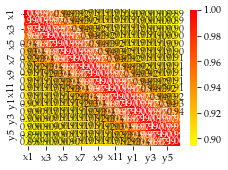

In [40]:
# Create correlation matrix
corr_matrix = train_df.corr(method='spearman')
# Plot
fig, axs = plt.subplots(1, 1,figsize=(3.5, 2.5))
sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.autumn_r, fmt='.2f', ax=axs)
#axs.set_title(f'Correlation analysis on times series data')

# Save the figure.
fig.savefig("corr_analysis.pdf", bbox_inches='tight')

In [41]:
y_test[:, 5].shape

(8592,)

# Linear regression model 

#### Creating model

In [42]:
MLR_model = LinearRegression()

#### Training the model

In [43]:
MLR_model.fit(x_train, y_train)

LinearRegression()

#### Prediction

In [45]:
y_hat_MLR = MLR_model.predict(x_test)



# Save the forecast in a CSV file.
forecast_MLR = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_MLR["TIMESTAMP"] = eval_df["dato_id"]
forecast_MLR["FORECAST"] = y_hat_MLR[:, 5]
forecast_MLR.to_csv("FYS_STK_ForecastTemplate-LR.csv")

#### Evaluation

In [47]:
RMSE_MLR = RMSE(y_test[:, 5], y_hat_MLR[:, 5])
print(f"Overall model score evaluated on training data using RMSE: {RMSE_MLR}")

Overall model score evaluated on training data using RMSE: 2.1358


-----


# XGBOOST

In [11]:
# fit model
#xgboost = XGBRegressor(objective='reg:squarederror', n_estimators=5000)
xgboost = XGBRegressor(objective='reg:squarederror', eta=0.1)
xgboost.fit(x_train, y_train)
# construct an input for a new preduction
#row = values[-6:].flatten()
# make a one-step prediction
yhat = xgboost.predict(x_test)
RMSE_xgboost = RMSE(y_test, yhat)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_xgboost}")

Overall model score evaluated on training data using RMSE: 4.2557


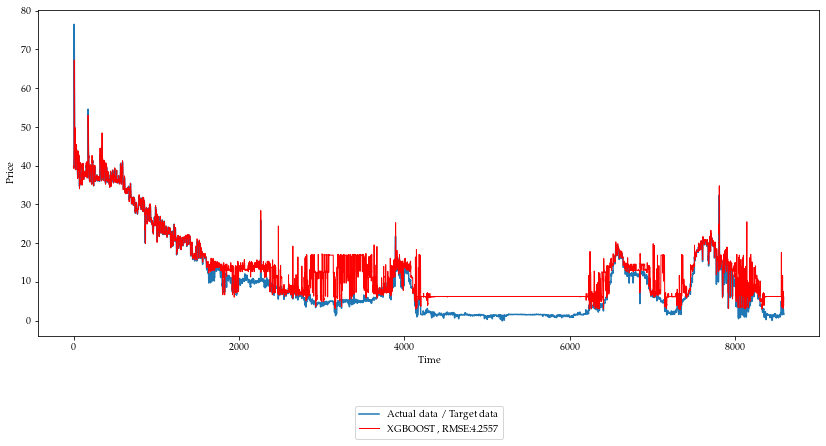

In [19]:
idx_from=0; 
idx_to=720
idx_to = y_test.shape[0]

x_plot = np.arange(x_test.shape[0])

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.plot(x_plot[idx_from:idx_to], y_test[idx_from:idx_to], label="Actual data / Target data")
ax.plot(x_plot[idx_from:idx_to], yhat[idx_from:idx_to], c="r",linewidth=1, label=f"XGBOOST , RMSE:{RMSE_xgboost}")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))



# Save the figure.
plt.savefig("forecast_plot0.pdf", bbox_inches='tight')



# SVR

#### Creating model

In [48]:
SVR_model = SVR(C=1.0, epsilon=0.05) 

#### Training the model

In [50]:
SVR_model.fit(x_train, y_train[:, 5].flatten()) 

SVR(epsilon=0.05)

#### Prediction

In [51]:
y_hat_SVR = SVR_model.predict(x_test)

print(y_hat_SVR.shape)

# Save the forecast in a CSV file.
forecast_SVR = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_SVR["TIMESTAMP"] = eval_df["dato_id"]
forecast_SVR["FORECAST"] = y_hat_SVR
forecast_SVR.to_csv("FYS_STK_ForecastTemplate-SVR.csv")

(8592,)


#### Evaluation

In [52]:
# Calculation the model score using RMSE
RMSE_SVR = RMSE(y_test[:, 5], y_hat_SVR)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_SVR}")

Overall model score evaluated on training data using RMSE: 9.7821


# Evaluation results

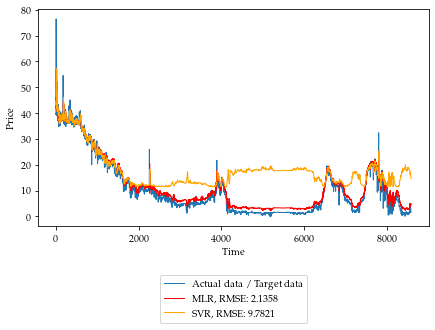

In [55]:
idx_from=0; 
#idx_to=720
idx_to = y_test.shape[0]

x_plot = np.arange(x_test.shape[0])

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.plot(x_plot[idx_from:idx_to], y_test[idx_from:idx_to, 5], linewidth=1, label="Actual data / Target data")
ax.plot(x_plot[idx_from:idx_to], y_hat_MLR[idx_from:idx_to, 5], c="r",linewidth=1, label=f"MLR, RMSE: {RMSE_MLR}")
ax.plot(x_plot[idx_from:idx_to], y_hat_SVR[idx_from:idx_to], c="orange", linewidth=1, label=f"SVR, RMSE: {RMSE_SVR}")
#ax.set_title(f"Predicted data using Multiple Linear Regression (MLR) and Support Vector Regression (SVR)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

# Save the figure.
plt.savefig("forecast_plot1.pdf", bbox_inches='tight')

# Neural Networks
We chose to use mean square error as our loss function. Adam is used as the optimizer.

# ANN - Simple architecture

#### Hyperparameters

In [ ]:
eta = 0.004
units = 32
batch_size = 500
EPOCHS = 100

#### Model architecture

In [ ]:
class ANN_simple(Sequential):
    def __init__(self, eta, units, nbf_outputs):
        super(self.__class__, self).__init__()
       
        self.add(Dense(units, activation='relu')) # First layer
        self.add(Dense(units//2, activation='relu')) # Second layer
        self.add(Dense(nbf_outputs)) # Output layer

        # Model optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
        
        ## Compile model
        self.compile(loss='mse',  optimizer=opt)

#### Create model

In [ ]:
ANN_model1 = ANN_simple(eta, units, nbf_outputs)

#### Preparing data for training and evaluation

In [ ]:
# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

#### Training the model

In [ ]:
ANN_model1.fit(x_train_ANN, y_train_ANN, shuffle=True, batch_size=batch_size, epochs=EPOCHS, verbose=0)
print(ANN_model1.summary())

#### Prediction

In [ ]:
y_hat_ANN1 = ANN_model1.predict(x_test_ANN)
y_hat_ANN1 = np.squeeze(y_hat_ANN1) # Removing excess dimensions

# Save the forecast in a CSV file.
forecast_ANN = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_ANN["TIMESTAMP"] = eval_df["dato_id"]
forecast_ANN["FORECAST"] = y_hat_ANN1.flatten()
forecast_ANN.to_csv("FYS_STK_ForecastTemplate-ANN.csv")

#### Evaluation

In [ ]:
# Calculation the model score using RMSE
RMSE_ANN1 = RMSE(y_test, y_hat_ANN1)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_ANN1}")

# ANN - Complex architecture

#### Hyperparameters

In [ ]:
decay= 1e-5
eta = 0.005
lam = 0.0001
units = 32
batch_size = 1000
drop = 0.2
EPOCHS=100

#### Model architecture

In [ ]:
class ANN_complex1(Sequential):
    def __init__(self, eta, lam, decay, units, drop,  nbf_outputs):
        super(self.__class__, self).__init__()
       
        # Initialization
        regz = tf.keras.regularizers.l2(lam)
        self.add(Dense(units, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units*2, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units*4, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units*2, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
        
        self.add(Dense(units//2, kernel_regularizer=regz, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(drop))
          
        self.add(Dense(nbf_outputs))

        # Model optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=eta, decay=decay)
        
        ## Compile model
        self.compile(loss='mse',  optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
        
        tf.keras.backend.clear_session()
        
    
    def fit(self, x_train, y_train, shuffle = True, batch_size = 32, epochs=100,
            validation_split=0.2, verbose=0):
        """
        Wrapper method that builds regularization into the training to 
        intentionally prevent overfitting. This method splits the
        training data into traning and validation such that validation 
        data can be used to validate the model during the traning process.
        """
        learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.000001)
        earlystop = EarlyStopping(patience=20)
        callbacks = [earlystop, learning_rate_reduction]
        
        return super().fit(x_train, y_train, shuffle=shuffle, batch_size=batch_size, epochs=epochs, 
                      validation_split=validation_split, callbacks= callbacks, verbose=verbose)

#### Create model

In [ ]:
ANN_model2 = ANN_complex1(eta, lam, decay, units, drop, nbf_outputs)

#### Preparing data for training and evaluation

In [ ]:
print(f"x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}")
# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

#### Training the model

In [ ]:
training = ANN_model2.fit(x_train_ANN, y_train_ANN,shuffle=True,batch_size=batch_size, epochs=EPOCHS,
               validation_split=0.1, verbose=0)
print(ANN_model2.summary())

In [ ]:
train_losses = np.array(training.history['loss'])
val_losses = np.array(training.history['val_loss'])
val_rmse = np.array(training.history['val_root_mean_squared_error'])
x = np.arange(train_losses.shape[0])

fig, ax = plt.subplots(figsize=(6, 2))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss values")
ax.plot(x, train_losses, linewidth=1, label="Training loss")
ax.plot(x, val_losses, linewidth=1, label="Validation loss")
ax.legend(loc="upper center")

plt.savefig("ANN_training.pdf", bbox_inches='tight')

The plot above indicates how the training went. We can see from the plot that the validation loss does not have an increasing trend, and it converge towards the training loss. This shows us that the model is not overfitted to the training data despite the relatively advanced model architecture. 

The model is constructed with regularization; regularizers, dropouts, early stopping, and learning rate reduction. The main purpose of regularization is to prevent underfitting and overfitting of the model and generalize it properly for new previously unseen data. The regularization definitely contributes to the curvature of the losses in the plot. However, it seems that the models we explored for this assignment were not so easy overfitted to the training data. The regularization may have been unnecessary considering the data we have and the setup we are using. 

#### Prediction

In [ ]:
y_hat_ANN2 = ANN_model2.predict(x_test_ANN)
y_hat_ANN2 = np.squeeze(y_hat_ANN2) # Removing excess dimensions

#### Evaluation

In [ ]:
# Calculation the model score using RMSE
RMSE_ANN2 = RMSE(y_test, y_hat_ANN2)
print(f"Overall model score evaluated on test data using RMSE: {RMSE_ANN2}")

# LSTM (RNN)
We are using the LSTM model as our RNN model. The LSTM is configured for a many-to-one problem using a bidirectional wrapper.

#### Hyperparameters

In [ ]:
eta = 0.004
units = 64
batch_size = 16
EPOCHS=100

#### Model architecture

In [ ]:
class LSTM_model(Sequential):
    def __init__(self, eta, units, model_shape, nbf_outputs):
        super(self.__class__, self).__init__()
       
        # Bidirectional LSTM layer
        self.add(Bidirectional(LSTM(units, input_shape = model_shape, return_sequences = True)))
                
        # Dense layer
        self.add(Dense(units, activation='relu'))

        # Output layer
        self.add(Dense(nbf_outputs))

        # Model compile settings
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
        
        ## Compile model
        self.compile(loss='mse', optimizer=opt)

#### Model shape
LSTM requires a shape of (batch_size, time_steps, num_features)

In [ ]:
time_steps = 72 # 72 hours = 3 days of history per training sequence
model_shape = (time_steps, nbf_features); print(model_shape)

#### Create model

In [ ]:
RNN_model1 = LSTM_model(eta, units, model_shape, nbf_outputs)

#### Preparing data for training and evaluation

In [ ]:
# Training data pre-processing
trainX = x_train[20:] # Discarding some samples to make the shapes add up
trainY = y_train[20:] # Discarding some samples to make the shapes add up

batch_size_train = x_train.shape[0] // time_steps
x_train_RNN = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN = trainY.copy()
y_train_RNN = y_train_RNN.reshape((batch_size_train, time_steps, 1))

# Test data pre-processing
batch_size_test = x_test.shape[0] // time_steps
x_test_RNN = x_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, 1))
y_test_RNN = y_test_RNN.flatten()

#### Training the model

In [ ]:
RNN_model1.fit(x_train_RNN, y_train_RNN, shuffle=True, batch_size=batch_size, epochs=EPOCHS, verbose=0)
print(RNN_model1.summary())

#### Prediction

In [ ]:
y_hat_RNN1 = RNN_model1.predict(x_test_RNN)
y_hat_RNN1 = y_hat_RNN1.flatten()

# Save the forecast in a CSV file.
forecast_RNN = pd.read_csv("FYS_STK_ForecastTemplate.csv", index_col=0)
forecast_RNN["TIMESTAMP"] = eval_df["dato_id"]
forecast_RNN["FORECAST"] = y_hat_RNN1
forecast_RNN.to_csv("FYS_STK_ForecastTemplate-RNN.csv")

#### Evaluation

In [ ]:
RMSE_RNN1 = RMSE(y_test_RNN, y_hat_RNN1)
print(RMSE_RNN1)

# Evaluation results

In [ ]:
idx_from=0; idx_to=720
x_plot = np.arange(x_test.shape[0])

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel("Time")
ax.set_ylabel("Power")
ax.plot(x_plot[idx_from:idx_to], y_test[idx_from:idx_to], label="Actual data / Target data")
ax.plot(x_plot[idx_from:idx_to], y_hat_ANN1[idx_from:idx_to], c="r",linewidth=1, label=f"ANN , RMSE:{RMSE_ANN1}")
ax.plot(x_plot[idx_from:idx_to], y_hat_RNN1[idx_from:idx_to], c="orange", linewidth=1, label=f"LSTM, RMSE:{RMSE_RNN1}")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

# Final results

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN1]}
results = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
results = results.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(results) 

-----


# Stateful LSTM (RNN)
We are using the LSTM model as our RNN model
Many-to-one configuration using the stateful flag

#### Hyperparameters

In [ ]:
eta = 0.004
units = 64
batch_size = 1
EPOCHS = 100

#### Model architecture

In [ ]:
# The best performing model
class LSTM_stateful_model(Sequential):
    def __init__(self, eta, units, model_shape, nbf_outputs):
        super(self.__class__, self).__init__()
       
        self.add(Bidirectional(LSTM(units, input_shape=model_shape, stateful=True, return_sequences = True)))
        self.add(Dense(units, activation='relu'))

        # Output layer
        self.add(TimeDistributed(Dense(1)))

        # Model compile settings
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
        
        ## Compile model
        self.compile(loss='mse', optimizer=opt)

#### Model shape
LSTM requires a shape of (batch_size, time_steps, num_features). Stateful models are trained using a fixed batch size of 1 since it uses the hidden state output from the previous batch as input to the initial hidden state for the current batch

In [ ]:
time_steps = 72 # 72 hours = 3 days of history per training sequence
model_shape = (time_steps, nbf_features); print(model_shape)

#### Create model

In [ ]:
RNN_model2 = LSTM_stateful_model(eta, units, model_shape, nbf_outputs)

#### Preparing data for training and evaluation

In [ ]:
# Training data pre-processing
trainX = x_train[20:] # Discarding some samples to make the shapes add up
trainY = y_train[20:] # Discarding some samples to make the shapes add up

batch_size_train = x_train.shape[0] // time_steps
x_train_RNN2 = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN2 = trainY.copy()
y_train_RNN2 = y_train_RNN2.reshape((batch_size_train, time_steps, 1))

# Test data pre-processing
batch_size_test = x_test.shape[0] // time_steps
x_test_RNN = x_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, 1))
y_test_RNN = y_test_RNN.flatten()

#### Training the model
Stateful LSTMs are trained differently than the default LSTM. Since they carry over the hidden state from batch-to-batch, the batch size must be 1. Shuffle must be false, since the order of the batches matter in the data series. Lastly the hidden state must be reset at the ende of the each epoch, otherwise the hidden state at the end of the dataset will be feed into the starte of the next epoch. You only want batches to be orderly chained, not epochs.  

In [ ]:
for e in range(EPOCHS):
    print(f"Training epoch {e}")
    RNN_model2.fit(x_train_RNN2, y_train_RNN2, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    RNN_model2.reset_states()
print(RNN_model2.summary())

#### Prediction

In [ ]:
y_hat_RNN2 = RNN_model2.predict(x_test_RNN, batch_size=1)
y_hat_RNN2 = y_hat_RNN2.flatten()

#### Evaluation

In [ ]:
RMSE_RNN2 = RMSE(y_test_RNN, y_hat_RNN2)
print(RMSE_RNN2)














# Evaluation results

In [ ]:
idx_from=0; idx_to=720
x_plot = np.arange(x_test.shape[0])

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xlabel("Time")
ax.set_ylabel("Power")
ax.plot(x_plot[idx_from:idx_to], y_test[idx_from:idx_to], linewidth=1, label="Actual data / Target data")
ax.plot(x_plot[idx_from:idx_to], y_hat_ANN1[idx_from:idx_to], c="r",linewidth=1, label=f"ANN, RMSE: {RMSE_ANN1}")
ax.plot(x_plot[idx_from:idx_to], y_hat_RNN2[idx_from:idx_to], c="orange", linewidth=1, label=f"RNN (LSTM), RMSE: {RMSE_RNN1}")
#ax.set_title(f"Predicted data using Artificial Neural Network (ANN) and Recurrent Neural Network (RNN)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

# Save the figure.
plt.savefig("forecast_plot2.pdf", bbox_inches='tight')

# Final results

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN1]}
RMSEs = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
RMSEs_styled = RMSEs.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(RMSEs_styled)

## A table of all relevant RMSEs

In [ ]:
RMSEs = RMSEs.T
RMSEs = RMSEs.rename({"RNN" : "RNN (LSTM)"})
RMSEs.to_csv("q3_RMSE.csv")

----------------------------
# Tests using different window size in the time series data

## Create windowed time series data

In [ ]:
# Training data
training_df = pd.read_csv("entsoe_dataset_main.csv")[["NO5_day_ahead_prices","dato_id"]][0:-8760]; print(training_df.shape)

# Forecast solutions
training_df, forcast_sol_df = train_test_split(training_df, shuffle=False, test_size=0.2, random_state=4155)

nbf_features = window_size = 20
nbf_outputs = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
x_train, y_train, x_test, y_test, train_df, eval_df = create_time_series_data(training_df, forcast_sol_df, window_size, nbf_outputs)

# Linear regression model 

In [ ]:
MLR_model2 = LinearRegression()
MLR_model2.fit(x_train, y_train)
y_hat_MLR2 = MLR_model2.predict(x_test)
RMSE_MLR2 = RMSE(y_test, y_hat_MLR2)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_MLR2}")

# SVR

In [ ]:
SVR_model2 = SVR(C=1.0, epsilon=0.05) 
SVR_model2.fit(x_train, y_train.flatten()) 
y_hat_SVR2 = SVR_model2.predict(x_test)
RMSE_SVR2 = RMSE(y_test, y_hat_SVR2)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_SVR2}")

# ANN - Simple architecture

In [ ]:
# Hyperparameters
eta = 0.004
units = 64
batch_size = 500
EPOCHS = 100

# Create model
ANN_model3 = ANN_simple(eta, units, nbf_outputs)

# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

# Training
ANN_model3.fit(x_train_ANN, y_train_ANN, shuffle=True, batch_size=batch_size, epochs=EPOCHS, verbose=0)

# Prediction
y_hat_ANN3 = ANN_model3.predict(x_test_ANN)
y_hat_ANN3 = np.squeeze(y_hat_ANN3) # Removing excess dimensions

# Calculation the model score using RMSE
RMSE_ANN3 = RMSE(y_test, y_hat_ANN3)
print(f"Overall model score evaluated on training data using RMSE: {RMSE_ANN3}")

# ANN - Complex architecture

In [ ]:
# Hyperparameters
decay= 1e-5
eta = 0.005
lam = 0.0001
units = 64
batch_size = 500
drop = 0.3
EPOCHS=100

# Create model
ANN_model4 = ANN_complex1(eta, lam, decay, units, drop, nbf_outputs)

# Reshaping the training data for it to fit to the model
x_train_ANN = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_train_ANN = np.swapaxes(x_train_ANN,1,2)
y_train_ANN = y_train.copy()

# Reshaping the test data for it to fit to the model
x_test_ANN = x_test.copy()
x_test_ANN = x_test_ANN.reshape((x_test_ANN.shape[0],x_test_ANN.shape[1],1))
x_test_ANN = np.swapaxes(x_test_ANN,1,2)

# Training
ANN_model4.fit(x_train_ANN, y_train_ANN,shuffle=True,batch_size=batch_size, epochs=EPOCHS,
               validation_split=0.1, verbose=0)

# Prediction
y_hat_ANN4 = ANN_model4.predict(x_test_ANN)
y_hat_ANN4 = np.squeeze(y_hat_ANN4) # Removing excess dimensions

# Calculation the model score using RMSE
RMSE_ANN4 = RMSE(y_test, y_hat_ANN4)
print(f"Overall model score evaluated on test data using RMSE: {RMSE_ANN4}")

# LSTM (RNN)

In [ ]:
# Hyperparameters
eta = 0.004
units = 64
batch_size = 16
EPOCHS=100

# Model shape
time_steps = 72 # 72 hours = 3 days of history per training sequence
model_shape = (time_steps, nbf_features); print(model_shape)

# Create model
RNN_model3 = LSTM_model(eta, units, model_shape, nbf_outputs)

# Training data pre-processing
trainX = x_train[4:]
trainY = y_train[4:]
batch_size_train = x_train.shape[0] // time_steps
x_train_RNN = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN = trainY.copy()
y_train_RNN = y_train_RNN.reshape((batch_size_train, time_steps, 1))

# Test data pre-processing
batch_size_test = x_test.shape[0] // time_steps
x_test_RNN = x_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, 1))
y_test_RNN = y_test_RNN.flatten()

# Training
RNN_model3.fit(x_train_RNN, y_train_RNN, shuffle=False, batch_size=batch_size, epochs=EPOCHS, verbose=0)

# Prediction
y_hat_RNN3 = RNN_model3.predict(x_test_RNN)
y_hat_RNN3 = y_hat_RNN3.flatten()

# Calculation the model score using RMSE
RMSE_RNN3 = RMSE(y_test_RNN, y_hat_RNN3)
print(RMSE_RNN3)

# Final results on window size of 20

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN3]}
RMSEs = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
RMSEs_styled = RMSEs.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(RMSEs_styled)

# Stateful LSTM (RNN)
Many-to-one configuration using the stateful flag

In [ ]:
# Hyperparameters
eta = 0.004
units = 64
batch_size = 1
EPOCHS = 100

# Model shape
time_steps = 72 # 72 hours = 3 days of history per training sequence
model_shape = (time_steps, nbf_features); print(model_shape)

# Create model
RNN_model4 = LSTM_stateful_model(eta, units, model_shape, nbf_outputs)

# Training data pre-processing
trainX = x_train[4:]
trainY = y_train[4:]
batch_size_train = x_train.shape[0] // time_steps
x_train_RNN4 = trainX.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN4 = trainY.copy()
y_train_RNN4 = y_train_RNN4.reshape((batch_size_train, time_steps, 1))

# Test data pre-processing
batch_size_test = x_test.shape[0] // time_steps
x_test_RNN = x_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, 1))
y_test_RNN = y_test_RNN.flatten()


# Training
for e in range(EPOCHS):
    print(f"Training epoch {e}")
    RNN_model4.fit(x_train_RNN4, y_train_RNN4, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    RNN_model4.reset_states()
    
# Prediction
y_hat_RNN4 = RNN_model4.predict(x_test_RNN, batch_size=1)
y_hat_RNN4 = y_hat_RNN4.flatten()

In [ ]:
# Calculation the model score using RMSE
RMSE_RNN4 = RMSE(y_test_RNN, y_hat_RNN4)
print(RMSE_RNN4)

# Final results on window size of 20

In [ ]:
data = {'RMSE': [RMSE_MLR, RMSE_SVR, RMSE_ANN1, RMSE_RNN4]}
RMSEs = pd.DataFrame.from_dict(data, orient='index',  columns=['MLR', 'SVR', 'ANN', 'RNN'])
RMSEs_styled = RMSEs.style.background_gradient(cmap='RdYlGn_r',axis=1)
display(RMSEs_styled)